In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import numba as nb
import pandas as pd
import netCDF4 as nc

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

import analog_utils as ana
import data_utils as du
import graph_utils as gu

from namelist import * 

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# Data

In [4]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    lon_4km = h5io['lon_4km'][...]
    lat_4km = h5io['lat_4km'][...]
    etopo_bc = h5io['etopo_bc'][...]
    etopo_4km = h5io['etopo_4km'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]
    land_mask_bc_4km = h5io['land_mask_bc_4km'][...]
bc_in_base = np.ones(land_mask.shape).astype(bool)
bc_in_base[bc_inds[0]:bc_inds[1], bc_inds[2]:bc_inds[3]] = land_mask_bc

etopo_bc[land_mask_bc] = np.nan
etopo_4km[land_mask_bc_4km] = np.nan

grid_shape = land_mask.shape
# subsetting by land mask
IND = []
for i in range(grid_shape[0]):
    for j in range(grid_shape[1]):
        if ~bc_in_base[i, j]:
            IND.append([i, j])
IND = np.array(IND, dtype=np.int)
N_grids = len(IND)

In [5]:
with h5py.File(save_dir+'SL20_d4_unique.hdf', 'r') as h5io:
    IxIy_unique = h5io['unique_inds'][...]
sl_lon = base_lon[IxIy_unique[:, 0], IxIy_unique[:, 0]]
sl_lat = base_lat[IxIy_unique[:, 0], IxIy_unique[:, 0]]

In [6]:
with h5py.File(ERA_dir+'ERA_monmean_2000_2020.hdf', 'r') as h5io:
    ERA5_monmean = h5io['monmean'][...]
    
ERA5_monmean = ERA5_monmean*1000
ERA5_monmean[:, land_mask] = np.nan

# with h5py.File(ERA_dir+'PT_3hour_90p.hdf', 'r') as h5io:
#     ERA_90p = h5io['era_90p'][...]

In [7]:
# with h5py.File(save_dir+'SL20_d4.hdf', 'r') as h5io:
#     SL_xy = h5io['SL_xy'][...]
# SL_xy = SL_xy.astype(int)

with h5py.File(save_dir+'SL40_d4.hdf', 'r') as h5io:
    SL_xy = h5io['SL_xy'][...]
    
SL_xy = SL_xy.astype(int)

# Figures

In [8]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [9]:
def aspc_cal(edge):
    return (edge[1]-edge[0])/(edge[3]-edge[2])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

In [10]:
def ind_to_edge(lon, lat, subset_ind):
    EDGE_x = np.array([lon[subset_ind[0], subset_ind[2]], 
                       lon[subset_ind[0], subset_ind[3]], 
                       lon[subset_ind[1], subset_ind[3]], 
                       lon[subset_ind[1], subset_ind[2]]])
    EDGE_y = np.array([lat[subset_ind[0], subset_ind[2]], 
                       lat[subset_ind[0], subset_ind[3]], 
                       lat[subset_ind[1], subset_ind[3]], 
                       lat[subset_ind[1], subset_ind[2]]])
    
    return EDGE_x, EDGE_y, np.array([[EDGE_x[0], EDGE_y[0]], 
                                     [EDGE_x[1], EDGE_y[1]], 
                                     [EDGE_x[2], EDGE_y[2]], 
                                     [EDGE_x[3], EDGE_y[3]]])

def domain_transfer_plot(size, edge, gap, IN_ETOPO, land_mask):
    size_center = size-2*edge
    grid_shape = land_mask.shape
    Ny = int(np.ceil((grid_shape[0])/size_center))+1
    Nx = int(np.ceil((grid_shape[1])/size_center))+1
    grid_shape_pad = (Ny*(size_center)+2*edge, Nx*(size_center)+2*edge)
    #
    Px, Py = (grid_shape_pad[1]-grid_shape[1]-edge)//gap, (grid_shape_pad[0]-grid_shape[0]-edge)//gap
    zero_pad = np.zeros((Px*Py,) + grid_shape_pad+(1,))*np.nan
    count = 0
    for i in range(Py):
        for j in range(Px):
            zero_pad[count, edge+gap*i:edge+gap*i+grid_shape[0], edge+gap*j:edge+gap*j+grid_shape[1], 0] = IN_ETOPO
            count += 1
    indx = np.arange(grid_shape_pad[1])
    indy = np.arange(grid_shape_pad[0])
    gridx, gridy = np.meshgrid(indx, indy)
    return gridx, gridy, zero_pad, Nx, Ny, size_center

def edge_gen(size, edge, N):
    return size+(N-1)*(size-2*edge)-2*edge

In [11]:
# gridx, gridy, zero_pad, Nx, Ny, size_center = domain_transfer_plot(48, 16, 8, 
#                                                                    etopo_025[bc_inds[0]:bc_inds[1], bc_inds[2]:bc_inds[3]], 
#                                                                    land_mask_bc)

In [12]:
# with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
#     lon_4km = h5io['lon_4km'][...]
#     lat_4km = h5io['lat_4km'][...]
#     etopo_4km = h5io['etopo_4km'][...]

In [13]:
# etopo_4km[lat_4km<48.25] = np.nan
# etopo_4km[lon_4km<-141] = np.nan

In [14]:
cmap_pct, A = gu.precip_cmap()
cmap_domain = colors.ListedColormap(A[4:7, :], 'hist')
cmap_terrain = colors.ListedColormap(plt.cm.terrain(np.arange(48, 256)), 'temp_cmap')

In [15]:
edge_bc = [-141-5.25, -113.25+2.75, 48.25-3, 60+3]
edge_base = [-147.25, -110.5, 32.75, 69.5]
edge_SL = [-142, -110.5, 43.25, 62]
EDGE = [edge_base, edge_bc, edge_SL, edge_SL]

r_bc = aspc_cal(edge_bc)
r_base = aspc_cal(edge_base)
r_sl = aspc_cal(edge_SL)
f = 0.01*gcd(int(100*r_bc), int(100*r_base))

## BCH station locations

In [16]:
# BCH metadata
with pd.HDFStore(BACKUP_dir+'BCH_85_metadata.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
    
stn_code = metadata['code'].values.tolist()
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev'].values

# bounding box of south and north wshed groups
south = [-130, -121, 48.75, 50.25]
north = [-127.5, -110, 53, 60]

# allocate 
loc_id = [] # south, rocky, north

# loop over stns and identify their wshed groups
for i in range(len(stn_code)):
    temp_lat = stn_lat[i]
    temp_lon = stn_lon[i]
    if du.check_bounds(temp_lon, temp_lat, south):
        loc_id.append(1)
    elif du.check_bounds(temp_lon, temp_lat, north):
        loc_id.append(3)
    else:
        loc_id.append(2)
        
loc_pick = np.array(loc_id)

# stn_pick = np.array(stn_code)[flag_pick]
# lon_pick = np.array(stn_lon)[flag_pick]
# lat_pick = np.array(stn_lat)[flag_pick]

# loc_pick = loc_id[flag_pick]

In [17]:
edge_bc = [-141, -113.25, 48.25, 60]
edge_base = [-147.25, -110.5, 32.75, 69.5]
edge_SL = [-142, -110.5, 43.25, 62]
EDGE = [edge_base, edge_bc, edge_SL, edge_SL]

r_bc = aspc_cal(edge_bc)
r_base = aspc_cal(edge_base)
r_sl = aspc_cal(edge_SL)
f = 0.01*gcd(int(100*r_bc), int(100*r_base))

In [18]:
# name_list = ['United States of America']
# geom_US = gu.get_country_geom(name_list)
shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'

## Figure (SL + Elev + BCH stns)

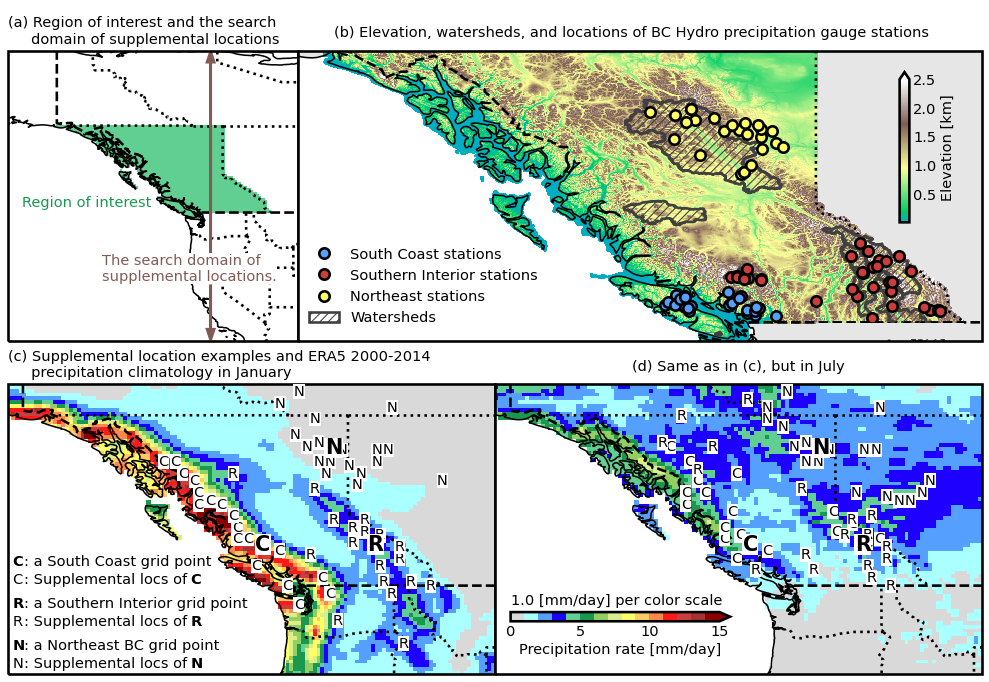

In [19]:
brown = plt.cm.terrain(np.arange(48, 256))[143, :]

M = ['C', 'N', 'R']

Ix = [85, 110, 85]
Iy = [96, 114, 125]

VMAX = [15, 15]
handle_text = []
handle_text_title = []
CS_ = []

title1 = ['(a) Region of interest and the search\n     domain of supplemental locations', 
          '(b) Elevation, watersheds, and locations of BC Hydro precipitation gauge stations']
title2 = ['(c) Supplemental location examples and ERA5 2000-2014\n     precipitation climatology in January', 
          '(d) Same as in (c), but in July']

fig = plt.figure(figsize=(13, (2.3/2)*26/(r_sl+r_sl)), dpi=dpi_) # 

gs = gridspec.GridSpec(4, 168, height_ratios=[0.15, 1, 0.15, 1], width_ratios=[1]*168)
ax_title1 = plt.subplot(gs[0, :])
ax_title2 = plt.subplot(gs[2, :])
ax1 = plt.subplot(gs[1, :50], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[1, 50:], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs[3, :84], projection=ccrs.PlateCarree())
ax4 = plt.subplot(gs[3, 84:], projection=ccrs.PlateCarree())
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX = [ax1, ax2, ax3, ax4]
AX_SL = [ax3, ax4]

handle_text_title.append(
    ax_title1.text(0, 0.1, title1[0], ha='left', va='bottom', fontsize=14, transform=ax_title1.transAxes))
handle_text_title.append(
    ax_title1.text(0.335, 0.25, title1[1], ha='left', va='bottom', fontsize=14, transform=ax_title1.transAxes))

handle_text_title.append(
    ax_title2.text(0, 0.1, title2[0], ha='left', va='bottom', fontsize=14, transform=ax_title2.transAxes))
handle_text_title.append(
    ax_title2.text(0.75, 0.25, title2[1], ha='center', va='bottom', fontsize=14, transform=ax_title2.transAxes))

ax_title1.set_axis_off()
ax_title2.set_axis_off()

for n, ax in enumerate(AX):
    ax.set_extent(EDGE[n], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
    
    if n == 1:
        ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
                          facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///')
        ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
        
    ax.spines['geo'].set_linewidth(2.5)

# ========== #
# Axis 1
ax1.pcolormesh(bc_lon, bc_lat, etopo_bc, vmin=3000, vmax=3000, cmap=cmap_domain)
ax1.text(0.05, 0.5, "Region of interest", ha='left', va='top', color=green, fontsize=14, transform=ax1.transAxes)
handle_text.append(ax1.text(0.325, 0.3, "The search domain of\nsupplemental locations.", 
                            ha='left', va='top', color=brown, fontsize=14, transform=ax1.transAxes))

ax1.arrow(0.7, 0.19, 0, -0.15, head_width=0.025, linewidth=2.5, color=brown, fc=brown, transform=ax1.transAxes)
ax1.arrow(0.7, 0.3, 0, 0.66, head_width=0.025, linewidth=2.5, color=brown, fc=brown, transform=ax1.transAxes)

# Axis 2
CS_elev = ax2.pcolormesh(lon_4km, lat_4km, 1e-3*etopo_4km, vmin=0.001, vmax=2.5, cmap=cmap_terrain)

handle1 = ax2.plot(stn_lon[loc_pick==1], stn_lat[loc_pick==1], 'ro', mfc=cyan, ms=10, mec='k', 
                  mew=2.5, zorder=4, label='South Coast stations')
handle2 = ax2.plot(stn_lon[loc_pick==2], stn_lat[loc_pick==2], 'ro', mfc=red, ms=10, mec='k', 
                  mew=2.5, zorder=4, label='Southern Interior stations')
handle3 = ax2.plot(stn_lon[loc_pick==3], stn_lat[loc_pick==3], 'ro', mfc=yellow, ms=10, mec='k', 
                  mew=2.5, zorder=4, label='Northeast stations')
handle_patch = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', label='Watersheds')

pad = 0.05
points = np.array([[-120, 48.25+pad], [-114, 48.25+pad], [-114, 49-pad], [-120, 49-pad],])
mask = PatchCollection([patches.Polygon(points)], facecolor='0.9', linewidth=0, zorder=6)
ax2.add_collection(mask)

# # ========== #
# # Axis 3 & 4
for n, ax in enumerate(AX_SL):
    if n == 0: 
        mon = 0
    else:
        mon = 6
    CS_.append(ax.pcolormesh(base_lon, base_lat, ERA5_monmean[mon, ...], vmin=0, vmax=VMAX[n], cmap=cmap_pct))
    for i in range(3):
        indx = Ix[i]
        indy = Iy[i]
        SL_indx = SL_xy[mon, indx, indy, :, 0]
        SL_indy = SL_xy[mon, indx, indy, :, 1]

        handle_text.append(ax.text(base_lon[indx, indy], base_lat[indx, indy], M[i], 
                                   fontsize=20, fontweight='bold', zorder=5))
        if i == 0:
            Js = np.arange(19, dtype=np.int)
        elif i == 1:
            Js = np.array(list(np.arange(15, dtype=np.int)) + [16, 17, 18, 19])
        else:
            Js = np.array(list(np.arange(17, dtype=np.int)) + [18, 19,])
            
        for j in Js:
            handle_text.append(ax.text(base_lon[SL_indx[j], SL_indy[j]], base_lat[SL_indx[j], SL_indy[j]], M[i], 
                                       fontsize=14, zorder=4))
for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0.4, edgecolor='none', zorder=4))
for handle in handle_text_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))

ax_w = fig.add_axes([0.005, 0.0, 0.215, 0.18])
ax_w.set_axis_off()
ax_w.text(0.0, 1, 'C', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 1, ": a South Coast grid point", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.85, 'C', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.85, ": Supplemental locs of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.85, 'C', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_w.text(0.0, 0.65, 'R', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 0.65, ": a Southern Interior grid point", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.5, 'R', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.5, ": Supplemental locs of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.5, 'R', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_w.text(0.0, 0.3, 'N', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 0.3, ": a Northeast BC grid point", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.15, 'N', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.15, ": Supplemental locs of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.15, 'N', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_lg = fig.add_axes([50/168, 0.5, 0.26, 0.16])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[handle1[0], handle2[0], handle3[0], handle_patch], 
               bbox_to_anchor=(1., 1.), ncol=1, prop={'size':14}, fancybox=False)
LG.get_frame().set_facecolor('none')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1.0)

ax_base = fig.add_axes([0.516, 0.0235+0.02, 0.225, 0.05])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='27.5%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_[1], orientation='horizontal', extend='max', cax=cax) #, ticks=[0, 2, 4, 6, 8, 10]
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Precipitation rate [mm/day]', fontsize=14)
CBar.outline.set_linewidth(2.5)

ax_w2 = fig.add_axes([0.516, 0.06+0.02, 0.05, 0.02])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '1.0 [mm/day] per color scale', ha='left', va='bottom', fontsize=14, transform=ax_w2.transAxes);

ax_base = fig.add_axes([0.915, 0.6775, 0.05, 0.225], facecolor='0.9')
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='100%', width='20%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_elev, orientation='vertical', extend='max', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.set_label('Elevation [km]', fontsize=14)
CBar.outline.set_linewidth(2.5)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_SL_domain.png', format='png', **fig_keys)

In [20]:
# brown = plt.cm.terrain(np.arange(48, 256))[143, :]

# handle_text = []
# handle_text_title = []
# CS_ = []

# title1 = ['(a) Region of interest and the search\n     domain of supplemental locations', 
#           '(b) Elevation, watersheds, and locations of BC Hydro precipitation gauge stations']

# fig = plt.figure(figsize=(13, (2.3/2)*13/(r_sl+r_sl)), dpi=dpi_) # 

# gs = gridspec.GridSpec(2, 168, height_ratios=[0.15, 1], width_ratios=[1]*168)
# ax_title1 = plt.subplot(gs[0, :])
# ax1 = plt.subplot(gs[1, :50], projection=ccrs.PlateCarree())
# ax2 = plt.subplot(gs[1, 50:], projection=ccrs.PlateCarree())
# plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# AX = [ax1, ax2]


# handle_text_title.append(
#     ax_title1.text(0, 0.1, title1[0], ha='left', va='bottom', fontsize=14, transform=ax_title1.transAxes))
# handle_text_title.append(
#     ax_title1.text(0.335, 0.25, title1[1], ha='left', va='bottom', fontsize=14, transform=ax_title1.transAxes))

# ax_title1.set_axis_off()


# for n, ax in enumerate(AX):
#     ax.set_extent(EDGE[n], ccrs.PlateCarree())
#     ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
#     ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
#     ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
    
#     if n == 1:
#         ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
#                           facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///')
#     ax.spines['geo'].set_linewidth(2.5)

# # ========== #
# # Axis 1
# ax1.pcolormesh(bc_lon, bc_lat, etopo_bc, vmin=3000, vmax=3000, cmap=cmap_domain)
# ax1.text(0.05, 0.5, "Region of interest", ha='left', va='top', color=green, fontsize=14, transform=ax1.transAxes)
# handle_text.append(ax1.text(0.2, 0.3, "A larger domain that supports\npost-processing model training.", 
#                             ha='left', va='top', color=brown, fontsize=14, transform=ax1.transAxes))

# ax1.arrow(0.7, 0.19, 0, -0.15, head_width=0.025, linewidth=2.5, color=brown, fc=brown, transform=ax1.transAxes)
# ax1.arrow(0.7, 0.3, 0, 0.66, head_width=0.025, linewidth=2.5, color=brown, fc=brown, transform=ax1.transAxes)

# # Axis 2
# CS_elev = ax2.pcolormesh(lon_4km, lat_4km, 1e-3*etopo_4km, vmin=0.001, vmax=2.5, cmap=cmap_terrain)

# handle1 = ax2.plot(stn_lon[loc_pick==1], stn_lat[loc_pick==1], 'ro', mfc=cyan, ms=10, mec='k', 
#                   mew=2.5, zorder=4, label='South Coast stations')
# handle2 = ax2.plot(stn_lon[loc_pick==2], stn_lat[loc_pick==2], 'ro', mfc=red, ms=10, mec='k', 
#                   mew=2.5, zorder=4, label='Southern Interior stations')
# handle3 = ax2.plot(stn_lon[loc_pick==3], stn_lat[loc_pick==3], 'ro', mfc=yellow, ms=10, mec='k', 
#                   mew=2.5, zorder=4, label='Northeast stations')
# handle_patch = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', label='Watersheds')

# pad = 0.05
# points = np.array([[-120, 48.25+pad], [-114, 48.25+pad], [-114, 49-pad], [-120, 49-pad],])
# mask = PatchCollection([patches.Polygon(points)], facecolor='w', linewidth=0, zorder=6)
# ax2.add_collection(mask)

# for handle in handle_text:
#     handle.set_bbox(dict(facecolor='w', pad=0.4, edgecolor='none', zorder=4))
# for handle in handle_text_title:
#     handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))

# ax_lg = fig.add_axes([50/168, 0.5-0.5, 0.26, 2*(0.16)])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=[handle1[0], handle2[0], handle3[0], handle_patch], 
#                bbox_to_anchor=(1., 1.), ncol=1, prop={'size':14}, fancybox=False)
# LG.get_frame().set_facecolor('none')
# LG.get_frame().set_linewidth(0)
# LG.get_frame().set_alpha(1.0)

# ax_base = fig.add_axes([0.915, 0.5*(0.6775), 0.05, 2*(0.225)])
# [j.set_linewidth(0) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, height='100%', width='20%', borderpad=0, loc=2)
# CBar = plt.colorbar(CS_elev, orientation='vertical', extend='max', cax=cax)
# CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
# CBar.set_label('Elevation [km]', fontsize=14)
# CBar.outline.set_linewidth(2.5)

# # if need_publish:
# #     # Save figure
# #     fig.savefig(fig_dir+'FC14_domain.png', format='png', **fig_keys)

In [21]:
name_list = ['United States of America']
geom_US = gu.get_country_geom(name_list, res='50m')

Selecting: United States of America


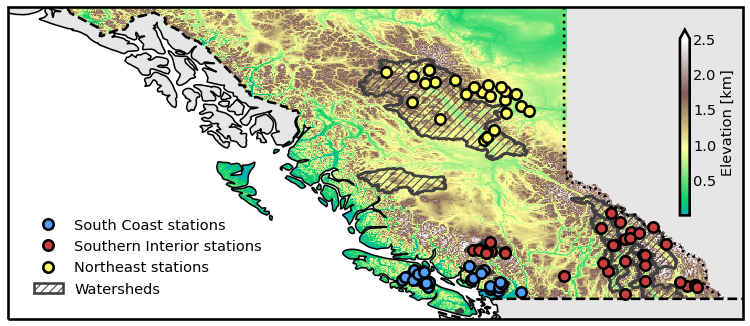

In [22]:
handle_text = []
handle_text_title = []
CS_ = []

fig = plt.figure(figsize=(13, 5.5), dpi=dpi_) # 
ax = plt.gca(projection=ccrs.PlateCarree())


ax.set_extent(EDGE[1], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=6)
ax.add_feature(cfeature.OCEAN.with_scale(scale_param), facecolor='w', zorder=4)
ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5, zorder=5)

ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', zorder=4)
ax.add_geometries(geom_US, ccrs.PlateCarree(),
                  facecolor='0.9', edgecolor='none', linewidth=0, zorder=5)
ax.spines['geo'].set_linewidth(2.5)
ax.spines['geo'].set_zorder(9)

# Axis 2
CS_elev = ax.pcolormesh(lon_4km, lat_4km, 1e-3*etopo_4km, vmin=0.004, vmax=2.5, cmap=cmap_terrain, zorder=3)

handle1 = ax.plot(stn_lon[loc_pick==1], stn_lat[loc_pick==1], 'ro', mfc=cyan, ms=10, mec='k', 
                  mew=2.5, zorder=8, label='South Coast stations')
handle2 = ax.plot(stn_lon[loc_pick==2], stn_lat[loc_pick==2], 'ro', mfc=red, ms=10, mec='k', 
                  mew=2.5, zorder=8, label='Southern Interior stations')
handle3 = ax.plot(stn_lon[loc_pick==3], stn_lat[loc_pick==3], 'ro', mfc=yellow, ms=10, mec='k', 
                  mew=2.5, zorder=8, label='Northeast stations')
handle_patch = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', label='Watersheds')

pad = 0.05
points = np.array([[-120, 48.25+pad], [-114, 48.25+pad], [-114, 49-pad], [-120, 49-pad],])
mask = PatchCollection([patches.Polygon(points)], facecolor='0.9', linewidth=0, zorder=6)
ax2.add_collection(mask)

# for handle in handle_text:
#     handle.set_bbox(dict(facecolor='w', pad=0.4, edgecolor='none', zorder=4))
# for handle in handle_text_title:
#     handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))

ax_lg = fig.add_axes([0.15, 0.15, 0.26, 0.25])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[handle1[0], handle2[0], handle3[0], handle_patch], 
               bbox_to_anchor=(1., 1.), ncol=1, prop={'size':14}, fancybox=False)
LG.get_frame().set_facecolor('none')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1.0)

ax_base = fig.add_axes([0.825, 0.375, 0.05, 2*(0.225)], facecolor='0.9')
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='100%', width='20%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_elev, orientation='vertical', extend='max', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.set_label('Elevation [km]', fontsize=14)
CBar.outline.set_linewidth(2.5)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'FC21_stn.png', format='png', **fig_keys)

In [23]:
era5_clim = np.load(save_dir+'ERA5_precip_rain_snow.npy', allow_pickle=True)[()]
fake_x = np.arange(12)

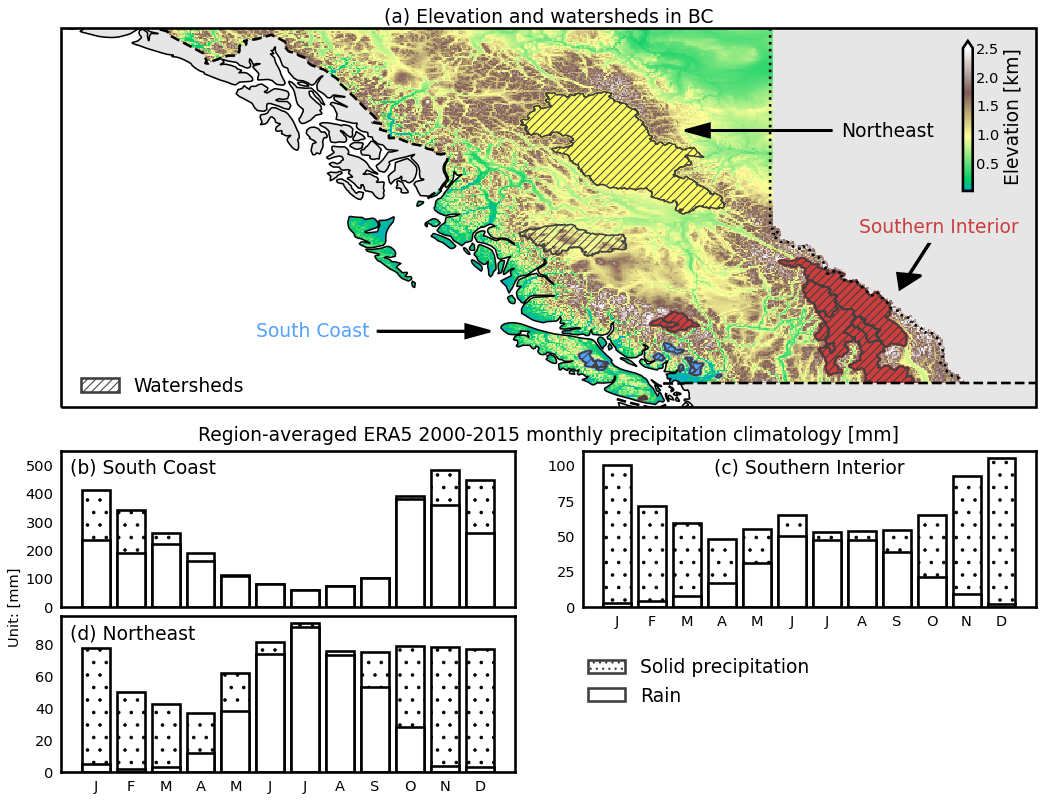

In [24]:
handle_text = []
handle_text_title = []
CS_ = []

fig = plt.figure(figsize=(13, 10), dpi=dpi_)

gs = gridspec.GridSpec(4, 2, height_ratios=[1, 0.05, 0.4, 0.4], width_ratios=[1, 1])

ax = plt.subplot(gs[0, :], projection=ccrs.PlateCarree())
ax0 = plt.subplot(gs[1, :])
ax1 = plt.subplot(gs[2, 0])
ax2 = plt.subplot(gs[2, 1])
ax3 = plt.subplot(gs[3, 0])

ax0.set_axis_off()

plt.subplots_adjust(0, 0, 1, 1, hspace=0.05, wspace=0.15)

ax.set_extent([-142, -111.75, 48.25, 60], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=6)
ax.add_feature(cfeature.OCEAN.with_scale(scale_param), facecolor='w', zorder=4)
ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5, zorder=5)


##########################################
SW_inds = [1, 2, 4, 5, 6, 7, 16, 18, 19, 21, 22, 23, 24]
SI_inds = [3, 8, 10, 11, 12, 13, 14, 15, 17, 20]
N_inds = [9,]
for i, temp_shape in enumerate(Reader(shape_dir).geometries()):
    if i in SW_inds:
        wshed_c = cyan
    elif i in SI_inds:
        wshed_c = red
    elif i in N_inds:
        wshed_c = yellow
    else:
        wshed_c = 'none'
        
    ax.add_geometries([temp_shape,], ccrs.PlateCarree(),
                  facecolor=wshed_c, edgecolor=wshed_c, linewidth=2.5, hatch='///', zorder=4)

ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='0.25', linewidth=1.5, hatch='///', zorder=4)
    
ax.add_geometries(geom_US, ccrs.PlateCarree(),
                  facecolor='0.9', edgecolor='none', linewidth=0, zorder=5)
ax.spines['geo'].set_linewidth(2.5)
ax.spines['geo'].set_zorder(9)

# Axis 2
CS_elev = ax.pcolormesh(lon_4km, lat_4km, 1e-3*etopo_4km, vmin=0.004, vmax=2.5, cmap=cmap_terrain, zorder=3)

ax.set_title('(a) Elevation and watersheds in BC', fontsize=18)

ax.text(0.2, 0.2, 'South Coast', fontsize=18, color=cyan, ha='left', va='center', transform=ax.transAxes, zorder=7)
ax.arrow(0.325, 0.2, 0.09, 0.0, head_width=0.035, head_length=0.025, 
         linewidth=2.5, fc='k', ec='k', transform=ax.transAxes, zorder=7)

ax.text(0.8, 0.73, 'Northeast', fontsize=18, ha='left', va='center', transform=ax.transAxes, zorder=7)
ax.arrow(0.79, 0.73, -0.125, 0.0, head_width=0.035, head_length=0.025, 
         linewidth=2.5, fc='k', ec='k', transform=ax.transAxes, zorder=7)

ax.text(0.9, 0.45, 'Southern Interior', fontsize=18, color=red, ha='center', va='bottom', transform=ax.transAxes, zorder=7)
ax.arrow(0.89, 0.43, -0.02, -0.08, head_width=0.025, head_length=0.04,
         linewidth=2.5, fc='k', ec='k', transform=ax.transAxes, zorder=7)

for ax_ in [ax1, ax2, ax3]:
    ax_ = gu.ax_decorate_box(ax_)
    ax_.tick_params(labelleft=True)
    ax_.xaxis.set_tick_params(labelsize=14)
    ax_.yaxis.set_tick_params(labelsize=14)

for ax_ in [ax2, ax3]:
    ax_.set_xticks(fake_x)
    ax_.tick_params(labelbottom=True)
    ax_.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

ax1.set_yticks([0, 100, 200, 300, 400, 500])
ax1.set_ylim([0, 550])

ax0.text(0.5, 0.35, 'Region-averaged ERA5 2000-2015 monthly precipitation climatology [mm]', 
         ha='center', va='center', fontsize=18, transform=ax0.transAxes)

ax1.text(0.02, 0.95, '(b) South Coast', ha='left', va='top', fontsize=18, transform=ax1.transAxes)
ax2.text(0.5, 0.95, '(c) Southern Interior', ha='center', va='top', fontsize=18, transform=ax2.transAxes)
ax3.text(0.02, 0.95, '(d) Northeast', ha='left', va='top', fontsize=18, transform=ax3.transAxes)

ax1.bar(fake_x, era5_clim['snow_sw'], linewidth=2.5, edgecolor='k', facecolor='none', hatch='.')
ax1.bar(fake_x, era5_clim['rain_sw'], linewidth=2.5, edgecolor='k', facecolor='w')

ax2.bar(fake_x, era5_clim['snow_si'], linewidth=2.5, edgecolor='k', facecolor='none', hatch='.')
ax2.bar(fake_x, era5_clim['rain_si'], linewidth=2.5, edgecolor='k', facecolor='w')

ax3.bar(fake_x, era5_clim['snow_n'], linewidth=2.5, edgecolor='k', facecolor='none', hatch='.')
ax3.bar(fake_x, era5_clim['rain_n'], linewidth=2.5, edgecolor='k', facecolor='w')

ax1.set_ylabel('Unit: [mm]', y=0, fontsize=14)

handle_patch1 = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, label='Rain')
handle_patch2 = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='..', label='Solid precipitation')

handle_patch_wshed = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', label='Watersheds')

ax_lg = fig.add_axes([0.005, 0.5, 0.2, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[handle_patch_wshed,], bbox_to_anchor=(1., 1.), ncol=1, prop={'size':18}, fancybox=False)
LG.get_frame().set_facecolor('none')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1.0)

ax_lg = fig.add_axes([0.535, 0.075, 0.25, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[handle_patch2, handle_patch1], bbox_to_anchor=(1., 1.), ncol=1, prop={'size':18}, fancybox=False)
LG.get_frame().set_facecolor('none')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1.0)

ax_base = fig.add_axes([0.925, 0.775, 0.05, 0.2], facecolor='0.9')
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='100%', width='20%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_elev, orientation='vertical', extend='max', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.set_label('Elevation [km]', fontsize=18)
CBar.outline.set_linewidth(2.5)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'FC14_domain.png', format='png', **fig_keys)

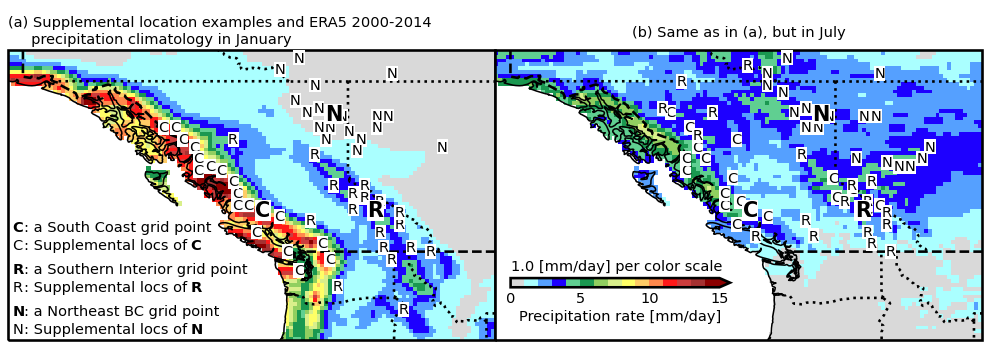

In [25]:
M = ['C', 'N', 'R']

Ix = [85, 110, 85]
Iy = [96, 114, 125]

VMAX = [15, 15]
handle_text = []
handle_text_title = []
CS_ = []

title1 = ['(a) Supplemental location examples and ERA5 2000-2014\n     precipitation climatology in January', 
          '(b) Same as in (a), but in July']

fig = plt.figure(figsize=(13, (2.3/2)*13/(r_sl+r_sl)), dpi=dpi_) # 

gs = gridspec.GridSpec(2, 168, height_ratios=[0.15, 1,], width_ratios=[1]*168)
ax_title1 = plt.subplot(gs[0, :])
ax3 = plt.subplot(gs[1, :84], projection=ccrs.PlateCarree())
ax4 = plt.subplot(gs[1, 84:], projection=ccrs.PlateCarree())
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX = AX_SL = [ax3, ax4]

handle_text_title.append(
    ax_title1.text(0, 0.1, title1[0], ha='left', va='bottom', fontsize=14, transform=ax_title1.transAxes))
handle_text_title.append(
    ax_title1.text(0.75, 0.25, title1[1], ha='center', va='bottom', fontsize=14, transform=ax_title1.transAxes))

ax_title1.set_axis_off()

for n, ax in enumerate(AX):
    ax.set_extent(EDGE[2+n], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
    ax.spines['geo'].set_linewidth(2.5)

# # ========== #
# # Axis 3 & 4
for n, ax in enumerate(AX_SL):
    if n == 0: 
        mon = 0
    else:
        mon = 6
    CS_.append(ax.pcolormesh(base_lon, base_lat, ERA5_monmean[mon, ...], vmin=0, vmax=VMAX[n], cmap=cmap_pct))
    for i in range(3):
        indx = Ix[i]
        indy = Iy[i]
        SL_indx = SL_xy[mon, indx, indy, :, 0]
        SL_indy = SL_xy[mon, indx, indy, :, 1]

        handle_text.append(ax.text(base_lon[indx, indy], base_lat[indx, indy], M[i], 
                                   fontsize=20, fontweight='bold', zorder=5))
        if i == 0:
            Js = np.arange(19, dtype=np.int)
        elif i == 1:
            Js = np.array(list(np.arange(15, dtype=np.int)) + [16, 17, 18, 19])
        else:
            Js = np.array(list(np.arange(17, dtype=np.int)) + [18, 19,])
            
        for j in Js:
            handle_text.append(ax.text(base_lon[SL_indx[j], SL_indy[j]], base_lat[SL_indx[j], SL_indy[j]], M[i], 
                                       fontsize=14, zorder=4))
for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0.4, edgecolor='none', zorder=4))
for handle in handle_text_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))

ax_w = fig.add_axes([0.005, 0.0, 0.215, 0.36])
ax_w.set_axis_off()
ax_w.text(0.0, 1, 'C', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 1, ": a South Coast grid point", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.85, 'C', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.85, ": Supplemental locs of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.85, 'C', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_w.text(0.0, 0.65, 'R', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 0.65, ": a Southern Interior grid point", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.5, 'R', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.5, ": Supplemental locs of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.5, 'R', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)

ax_w.text(0.0, 0.3, 'N', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)
ax_w.text(0.055, 0.3, ": a Northeast BC grid point", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.0, 0.15, 'N', fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.055, 0.15, ": Supplemental locs of ", fontsize=14, ha='left', va='top', transform=ax_w.transAxes)
ax_w.text(0.85, 0.15, 'N', fontsize=14, ha='left', va='top', fontweight='bold', transform=ax_w.transAxes)


ax_base = fig.add_axes([0.516, 2*(0.0235+0.02), 0.225, 0.1])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='27.5%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS_[1], orientation='horizontal', extend='max', cax=cax) #, ticks=[0, 2, 4, 6, 8, 10]
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Precipitation rate [mm/day]', fontsize=14)
CBar.outline.set_linewidth(2.5)

ax_w2 = fig.add_axes([0.516, 2*(0.06+0.02), 0.05, 0.04])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '1.0 [mm/day] per color scale', ha='left', va='bottom', fontsize=14, transform=ax_w2.transAxes);

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'FC31_SL_examples.png', format='png', **fig_keys)